# Assignment 2 - Epipolar Geometry and 3D Reconstruction 

First name: Nalet
<br>
Last name: Meinen
<br>
Matriculation number: 13-463-955

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import numpy as np
from PIL import Image
import ipyvolume as ipv
import matplotlib.pyplot as plt

from utils import decompose_essential_matrix, infer_3d, ransac

## Part II: 3D Model Reconstruction

### Load matched points
We provide a synthetic pair of images where noisy correspondences are known.

In [2]:
left = np.array(Image.open(os.path.join('MatchedPoints','left.jpg')), dtype=np.float32).mean(2)/255
right = np.array(Image.open(os.path.join('MatchedPoints','right.jpg')), dtype=np.float32).mean(2)/255

Text(0.5, 1.0, 'Right image')

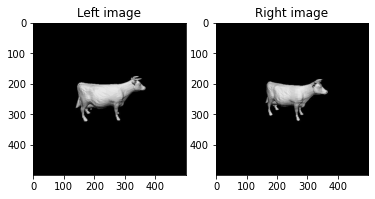

In [3]:
plt.subplot(1,2,1)
plt.imshow(left, cmap='gray')
plt.title('Left image')
plt.subplot(1,2,2)
plt.imshow(right, cmap='gray')
plt.title('Right image')

In [4]:
ilias_username = "n.meinen" # TODO
A = np.loadtxt(f'MatchedPoints/Matched_Points_{ilias_username}.txt')

In [5]:
M, N = A.shape
leftPoints = np.concatenate((A[:,2:4].T, np.ones((1, M))), axis=0)
rightPoints = np.concatenate((A[:,0:2].T, np.ones((1, M))), axis=0)

### Calibration matrix and focal length from the given file

In [6]:
fl = 4
K = np.array([
    [-83.33333, 0.00000, 250.00000],
    [0.00000, -83.33333, 250.00000],
    [0.00000, 0.00000,   1.00000],
])

I = K.copy()

I[0,0] *= fl
I[1,1] *= fl

### Estimate Essential matrix E from F with RANSAC

In [24]:
good_threshold = 0.1 # TODO
F, inliers = ransac(leftPoints, rightPoints, good_threshold)
print('Num outliers', leftPoints.shape[1] - inliers.shape[0]) #we correct it as we cannot sum idx
assert np.linalg.matrix_rank(F) == 2
print('Estimated fundamental matrix: ')
print(F)

# TODO: Estimate essential matrix E from F
E = I.T @ F @ I

print('Estimated essential matrix: ')
print(E)


Num outliers 3447
Estimated fundamental matrix: 
[[-1.58905049e-07  1.93470041e-05 -7.19478797e-03]
 [-1.17279713e-06 -2.23822334e-06 -1.62406433e-02]
 [ 3.37597496e-04  1.18904927e-02  1.81664614e+00]]
Estimated essential matrix: 
[[-1.76561151e-02  2.14966695e+00  7.99254375e-01]
 [-1.30310782e-01 -2.48691462e-01  5.69779925e+00]
 [-1.55731727e-03 -5.38922909e+00  8.78284269e-04]]


### Compute rotation and translation between views

In [15]:
# TODO: Compute rotation and translation between views. Complete decomposeE
Il = np.linalg.solve(I, leftPoints)
Ir = np.linalg.solve(I, rightPoints)

Pl, Pr = decompose_essential_matrix(-E, Il, Ir)

print('Estimated translation: ')
print(Pr[:,3])
print('Estimated rotation: ')
print(Pr[:,:3])

Estimated translation: 
[ 0.91901457 -0.12897148  0.37252997]
Estimated rotation: 
[[ 0.92725869  0.13700572 -0.3484548 ]
 [-0.12973386  0.99056142  0.04424025]
 [ 0.35122705  0.00418423  0.93628097]]


### Estimate the 3D points

In [16]:
x3D = infer_3d(Il, Ir, Pl, Pr)
ipv.quickscatter(x=x3D[0,:], y=x3D[1,:], z=x3D[2,:])

In [34]:
Rr = np.array([[0.92848, - 0.12930, 0.34815], 
               [0,         0.93744, 0.34815], 
               [-0.37139, -0.32325, 0.87039]])

tr = np.array([2, 2, 5])

Rl = np.array([[1,  0,       0      ], 
               [0,  0.92848, 0.37139], 
               [0, -0.37139, 0.92848]])

tl = np.array([0, 2, 5])

R_est = Pr[:,:3]
t_est = Pr[:,3] 

H_est = np.identity(4)
H_est[:3, :4] = Pr 

Hr = np.identity(4)
Hr[:3,:3] = Rr
Hr[:3, 3] = tr

Hl = np.identity(4)
Hl[:3,:3] = Rl
Hl[:3, 3] = tl

H_gt = Hr @ np.linalg.inv(Hl)

R_gt = H_gt[:3, :3]
t_gt = H_gt[:3, 3]

beta_est  = np.arctan2(-R_est[2, 0],                       np.sqrt(R_est[0, 0] ** 2 + R_est[1, 0] ** 2 ))
alpha_est = np.arctan2( R_est[2, 1] / np.cos(beta_est),    R_est[2, 2] / np.cos(beta_est))
gamma_est = np.arctan2( R_est[1, 0] / np.cos(beta_est),    R_est[0, 0] / np.cos(beta_est))

beta_gt   = np.arctan2(-R_gt[2, 0],                        np.sqrt(R_gt[0, 0] ** 2 + R_gt[1, 0] ** 2 ))
alpha_gt  = np.arctan2( R_gt[2, 1] / np.cos(beta_gt),      R_gt[2, 2] / np.cos(beta_gt)) 
gamma_gt  = np.arctan2( R_gt[1, 0] / np.cos(beta_gt),      R_gt[0, 0] / np.cos(beta_gt)) 

print("l-norm rot: \t", np.sum((np.abs(alpha_est - alpha_gt), np.abs(beta_est - beta_gt), np.abs(gamma_est - gamma_gt))) * 180/np.pi)
print("l-norm trans: \t", np.sum(np.abs(t_est - t_gt)))

l-norm rot: 	 51.49930463712777
l-norm trans: 	 1.1076824922195605
